In [2]:
#Import all the required libraries
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



Read the English-German sentence pairs using the function defined below and split the lines initially wrt new lines and then wrt tab space.

In [0]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text
    
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [0]:
data = read_text("/content/drive/My Drive/NMT/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

We totally have 150000 pairs of German-English translation, so depending upon the computation capacity we can select the amount of training data. I utilized the GPU provision of google colab.

In [0]:
deu_eng = deu_eng[:150000,:2]

In [7]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ["It's a good thing that you showed up.",
        'Es ist gut, dass du vorbeigekommen bist.'],
       ["It's a lot of fun to listen to music.",
        'Musik zu hören macht sehr viel Spaß.'],
       ["It's a matter of personal preference.",
        'Das ist eine Frage des persönlichen Geschmacks.']], dtype='<U537')

Text Pre-Processing

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['Its a good thing that you showed up',
        'Es ist gut dass du vorbeigekommen bist'],
       ['Its a lot of fun to listen to music',
        'Musik zu hören macht sehr viel Spaß'],
       ['Its a matter of personal preference',
        'Das ist eine Frage des persönlichen Geschmacks']], dtype='<U537')

In [9]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['its a good thing that you showed up',
        'es ist gut dass du vorbeigekommen bist'],
       ['its a lot of fun to listen to music',
        'musik zu hören macht sehr viel spaß'],
       ['its a matter of personal preference',
        'das ist eine frage des persönlichen geschmacks']], dtype='<U537')

Before feeding the data to our Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length and hence we tokenize them with the help of Tokenizer.

In [0]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 12061


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 23549


To make all the sentences look alike in terms of dimensions we will have to pad every sentences such that all the sentences are of same dimension.

In [0]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

**Train-Test split**

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 256)

**HYPER PARAMETERS:**
- Units : Number of LSTM cells
- Activation : Softmax is the default activation for the last layer in our problem statement.
- Optimizer: You can use any optimizer of your choice(Sigmoid, ReLu)
- Epochs: Depending upon your computation capacity you can either increase the epoch or decrease it but usually the validation loss gets stabilized after certain epochs.
- Batch size: No of sentences for every pass

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [20]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 96000 samples, validate on 24000 samples
Epoch 1/30
96000/96000 [==============================] - 46s 480us/step - loss: 4.4412 - val_loss: 4.0395

Epoch 00001: val_loss improved from inf to 4.03951, saving model to model.h1.24_jan_19
Epoch 2/30
96000/96000 [==============================] - 44s 459us/step - loss: 3.9071 - val_loss: 3.7975

Epoch 00002: val_loss improved from 4.03951 to 3.79749, saving model to model.h1.24_jan_19
Epoch 3/30
96000/96000 [==============================] - 44s 461us/step - loss: 3.6796 - val_loss: 3.5790

Epoch 00003: val_loss improved from 3.79749 to 3.57896, saving model to model.h1.24_jan_19
Epoch 4/30
96000/96000 [==============================] - 44s 459us/step - loss: 3.4512 - val_loss: 3.3791

Epoch 00004: val_loss improved from 3.57896 to 3.37907, saving model to model.h1.24_jan_19
Epoch 5/30
96000/96000 [==============================] - 44s 461us/step - loss: 3.2454 - val_loss: 3.2171

Epoch 00005: val_loss improved from 3.37907 to 3.2

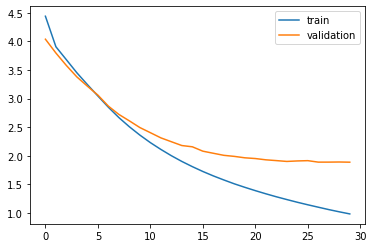

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [26]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
4876,i didnt pay,i didnt paid
22445,my wife didnt come with me,my mother didnt come with
2685,i always carry it in my pocket,can you still my with
14986,i like music and english,i like english
5930,tom saw us do that,tom looked us do
10172,are your parents going to be home,are home your home
24403,you shouldve called me sooner,you shouldve call me
8516,that water pipe leaks,the storm has a interest
27265,did you get my flowers,did you get my flowers
20250,i want you to stay,i want you to them


- So the above Seq2Seq model does a pretty decent job in translating the sentences. Further we could try optimizing the hyper parameters and increasing the number of training data points. 
- This is just the first version of the code, a more advanced model with **ATTENTION** layer between the encoder and decoder architecture will be developed shortly.